### Irish food Market Analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from supabase import create_client, Client
from dotenv import load_dotenv

In [20]:
# Connect to Supabase where the data is stored
# 1. SETUP
load_dotenv()
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, key)

print("Fetching Irish data for Machine Learning...")
response = supabase.table("food_items") \
    .select("product_name, ingredients_text, nova_group, sugar_100g, category_searched, salt_100g") \
    .or_("countries_sold.ilike.%Ireland%,countries_sold.ilike.%en:ie%") \
    .neq("ingredients_text", "") \
    .limit(2000) \
    .execute()

df = pd.DataFrame(response.data)
print(f"Loaded {len(df)} products.")

Fetching Irish data for Machine Learning...
Loaded 1000 products.


In [3]:
# Found that a lot of products contained German ingredients (or German spelling of ingredients to be precise)
# Filtering out common German spelling
german_keywords = ['zucker', 'wasser', 'spiesesalz', 'weizenmehl']
df = df[~df['ingredients_text'].str.lower().apply(lambda x: any(k in x for k in german_keywords))]
initial_count = len(df)
print(f"Removed {initial_count - len(df)} non-English products. Remaining: {len(df)}")

Removed 0 non-English products. Remaining: 932


In [4]:
# 2. VECTORIZATION (TF-IDF)
# Convert text to numbers. Ignoring words that appear in >50% of docs (max_df)
# to filter out generic terms like "water" if they are too common.
vectoriser = TfidfVectorizer(stop_words='english', max_df=0.5, max_features=1000)
X = vectoriser.fit_transform(df['ingredients_text'])

print(f"Matrix Shape: {X.shape} (Products x Unique Ingredients)")

Matrix Shape: (932, 1000) (Products x Unique Ingredients)


Running Manual Elbow Analysis...


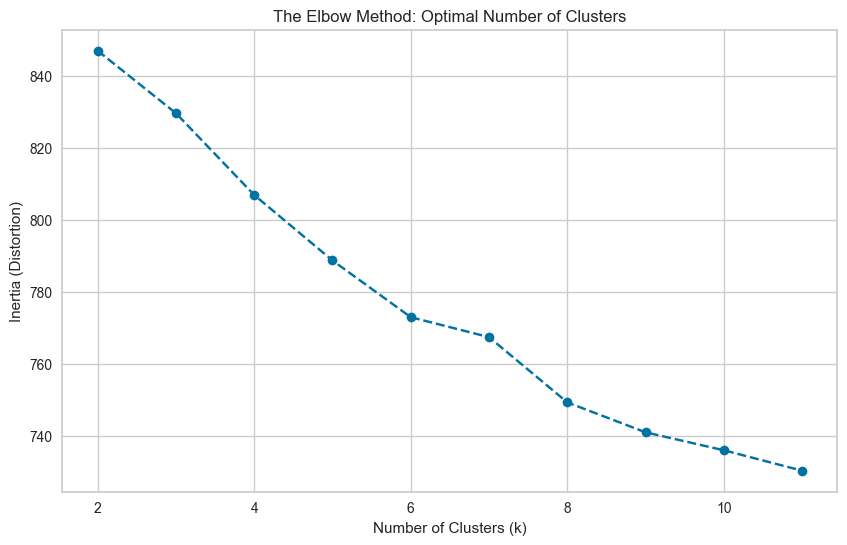

In [7]:
# CELL 2: The Elbow Method (Manual Version)
# This removes the Yellowbrick dependency to avoid version errors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

print("Running Manual Elbow Analysis...")

inertia = []
K_range = range(2, 12)

for k in K_range:
    # 1. Create a fresh model for every 'k'
    model = KMeans(n_clusters=k, random_state=42)
    
    # 2. Fit it to the matrix
    model.fit(X)
    
    # 3. Capture the 'Inertia' (Error score)
    inertia.append(model.inertia_)

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('The Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Distortion)')
plt.grid(True)
plt.show()

Running Silhouette Analysis for k=5...
For n_clusters = 5, the average silhouette_score is: 0.037


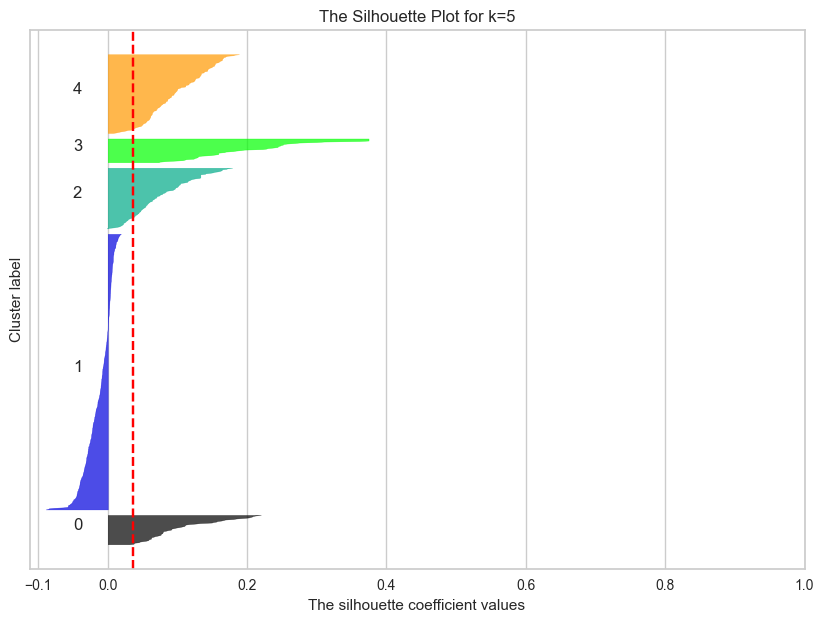

In [8]:
# CELL 3: Silhouette Analysis for k=5
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import numpy as np

print("Running Silhouette Analysis for k=5...")

# 1. Choose the cluster number we want to evaluate
k = 5
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(X)

# 2. Calculate the average score (The "Grade")
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"For n_clusters = {k}, the average silhouette_score is: {silhouette_avg:.3f}")

# 3. Compute scores for each sample to plot them
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# 4. Create the Plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

y_lower = 10
for i in range(k):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title(f"The Silhouette Plot for k={k}")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Running Stratified Test: Gluten-Free vs Standard (Biscuits/Cookies Only)...
Total Biscuit/Cookie Products found: 44
Sample Sizes -> Gluten-Free: 4 | Standard: 996


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.067454,3.014966,two-sided,0.950445,"[-26.19, 27.32]",0.042836,0.429,0.050836


C:\Users\seanq\AppData\Local\Temp\ipykernel_11820\1286267367.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Sugar (g/100g)', data=plot_data, palette="muted", inner="quartile")


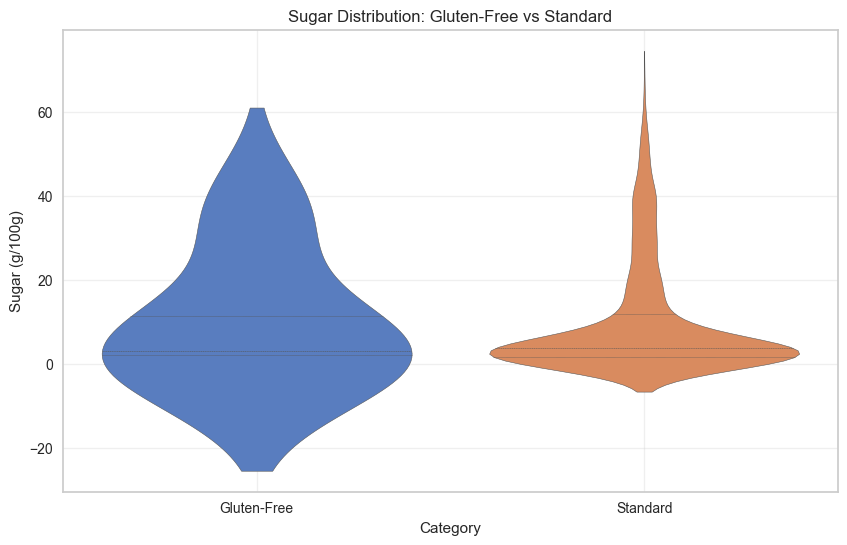

In [16]:
# Hypothesis Testing for gluten free food. 
import pingouin as pg 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

print("Running Stratified Test: Gluten-Free vs Standard (Biscuits/Cookies Only)...")

# 1. Create a Subset: Only items containing "biscuit", "cookie", or "cracker"
subset = df[df['product_name'].str.lower().str.contains('biscuit|cookie|cracker', na=False)].copy()

print(f"Total Biscuit/Cookie Products found: {len(subset)}")

# Extract sugar values and ensure they are numbers (floats)
gf_sugar = df[df['is_gluten_free'] == True]['sugar_100g'].dropna().astype(float)
std_sugar = df[df['is_gluten_free'] == False]['sugar_100g'].dropna().astype(float)

print(f"Sample Sizes -> Gluten-Free: {len(gf_sugar)} | Standard: {len(std_sugar)}")

# 2. Run the T-Test
# correction='auto' automatically applies Welch's correction if variances are unequal
results = pg.ttest(gf_sugar, std_sugar, correction='auto')

# 3. Display the "Publication-Ready" Table
# This prints a beautiful row with T-val, p-val, Cohen-d (effect size), and Power
display(results)

# 4. Visualization (Violin Plot - better than boxplot for showing distribution shape)
plt.figure(figsize=(10, 6))
plot_data = pd.DataFrame({
    'Sugar (g/100g)': pd.concat([gf_sugar, std_sugar]),
    'Category': ['Gluten-Free'] * len(gf_sugar) + ['Standard'] * len(std_sugar)
})

sns.violinplot(x='Category', y='Sugar (g/100g)', data=plot_data, palette="muted", inner="quartile")
plt.title('Sugar Distribution: Gluten-Free vs Standard')
plt.grid(True, alpha=0.3)
plt.show()

--- DATA DIAGNOSTIC ---
category_searched
Cereal      191
Bread       154
Yogurt      150
Crisps      144
Biscuits    134
Soup         69
Pizza        42
Cheese       40
Jam          40
Sausages     35
Name: count, dtype: int64
------------------------------
Sample Sizes -> Soup: 69 | Crisps: 144

Running T-Test: Salt Content (Soup vs Crisps)...


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.123492,73.606981,two-sided,0.902054,"[-0.76, 0.67]",0.024604,0.16,0.053212


C:\Users\seanq\AppData\Local\Temp\ipykernel_11820\1778080814.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Salt (g/100g)', data=plot_data, palette="coolwarm")


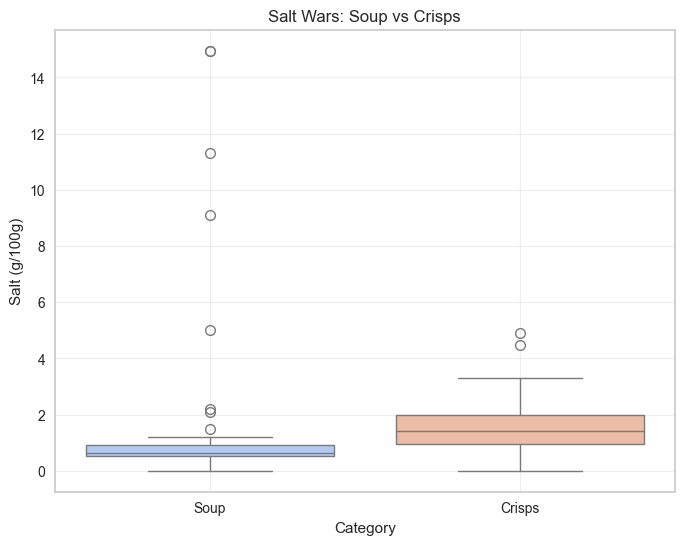

In [25]:
# CELL 5 (Alternative): The "Salt War" - Soup vs Crisps
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

# 1. First, let's see what categories we actually have enough data for
print("--- DATA DIAGNOSTIC ---")
print(df['category_searched'].value_counts().head(10))
print("-" * 30)

# 2. Define the two groups (Using the 'category_searched' column from your screenshot)
group_a = "Soup"
group_b = "Crisps"

# Filter the data
salt_a = df[df['category_searched'] == group_a]['salt_100g'].dropna().astype(float)
salt_b = df[df['category_searched'] == group_b]['salt_100g'].dropna().astype(float)

print(f"Sample Sizes -> {group_a}: {len(salt_a)} | {group_b}: {len(salt_b)}")

# 3. Run the T-Test (if we have data)
if len(salt_a) > 10 and len(salt_b) > 10:
    print(f"\nRunning T-Test: Salt Content ({group_a} vs {group_b})...")
    results = pg.ttest(salt_a, salt_b, correction='auto')
    display(results)

    # 4. Visualize
    plt.figure(figsize=(8, 6))
    plot_data = pd.DataFrame({
        'Salt (g/100g)': pd.concat([salt_a, salt_b]),
        'Category': [group_a] * len(salt_a) + [group_b] * len(salt_b)
    })
    
    sns.boxplot(x='Category', y='Salt (g/100g)', data=plot_data, palette="coolwarm")
    plt.title(f'Salt Wars: {group_a} vs {group_b}')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Not enough data points in these categories.")

In [26]:
salt_bombs = df[
    (df['category_searched'] == 'Soup') & 
    (df['salt_100g'] > 5)
][['product_name', 'salt_100g']]

display(salt_bombs)

,product_name,salt_100g
861,Beef stock pot,14.95
862,Beef Stock Pot 8 x,14.95
893,Erin Hotcup Chicken,11.30
901,Instant miso soup,9.10


In [2]:
# Fit K-Means with k=4 and add cluster labels to the dataframe
from collections import Counter

model = KMeans(n_clusters=4, random_state=42)
df['cluster'] = model.fit_predict(X)

print(f"Cluster distribution:\n{df['cluster'].value_counts().sort_index()}\n")

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = vectoriser.get_feature_names_out()

# Print top 10 words for each cluster based on centroid weights
print("=" * 60)
print("TOP 10 WORDS PER CLUSTER (by TF-IDF centroid importance)")
print("=" * 60)

for cluster_id in range(4):
    # Get the centroid for this cluster (average TF-IDF weights)
    centroid = model.cluster_centers_[cluster_id]
    
    # Get indices of top 10 words sorted by weight
    top_indices = centroid.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    
    print(f"\n🏷️  CLUSTER {cluster_id} ({(df['cluster'] == cluster_id).sum()} products):")
    print(f"   {', '.join(top_words)}")

NameError: name 'KMeans' is not defined